In [1]:
#fastai study group.  learning my way around Kaggle.  Not competing yet.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [3]:
from fastai.tabular.all import *
path = Path('../input/lish-moa')
path.ls()

(#6) [Path('../input/lish-moa/sample_submission.csv'),Path('../input/lish-moa/train_drug.csv'),Path('../input/lish-moa/train_targets_scored.csv'),Path('../input/lish-moa/train_targets_nonscored.csv'),Path('../input/lish-moa/train_features.csv'),Path('../input/lish-moa/test_features.csv')]

In [4]:
train_features = pd.read_csv(path/'train_features.csv')
test_features = pd.read_csv(path/'test_features.csv')
train_targets = pd.read_csv(path/'train_targets_scored.csv')
train_drugs = pd.read_csv(path/'train_drug.csv')
sub = pd.read_csv(path/'sample_submission.csv')

In [5]:
##merge drugs and features
#train_features_original = train_features.copy()

#train_features = train_features.merge(train_drugs)
#print(train_features.shape)
#train_features.head()

In [6]:
#finding about all drugs cacb2b860 being ctl_vehicle
#merge drugs and features
train_features_origianl = train_features.copy()

#exclude those
train_features = train_features[train_features['cp_type'] != 'ctl_vehicle'].copy()
print(train_features.shape)
train_features.head()

(21948, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [7]:
train_features.shape, train_targets.shape

((21948, 876), (23814, 207))

In [8]:
#data prep
categorical = ['cp_type', 'cp_time', 'cp_dose'] #, 'drug_id'
continuous = [i for i in train_features.columns if i not in ['cp_type', 'cp_time', 'cp_dose',  'sig_id']] #'drug_id',
dep_var = [i for i in train_targets.columns if i != 'sig_id']
train_features[dep_var] = train_targets[dep_var]
train_features.shape

(21948, 1082)

In [9]:
# We have appended the targets to the features dataframe
train_features.iloc[1:5,-5:-1]

,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [10]:
n_train = np.rint(train_features.shape[0]*0.8).astype(int)
n_train

17558

In [11]:
indices = np.random.permutation(train_features.shape[0])
train_idx, test_idx = indices[:n_train], indices[n_train:]
splits = (list(train_idx), list(test_idx))


In [12]:
procs = [FillMissing, Categorify, Normalize]
data = TabularPandas(train_features, procs=procs, cat_names=categorical,
                    cont_names=continuous, y_names=dep_var, splits = splits)

In [13]:
len(data.train), len(data.valid)

(17558, 4390)

In [14]:
data.show(10)


In [15]:
#data loaders
dls = data.dataloaders(512)

In [16]:
#setup learner
learn = tabular_learner(dls, layers=[600,300], loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0020892962347716093)

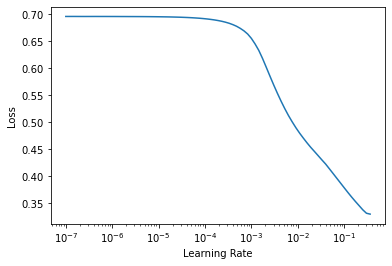

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,time
0,0.216526,0.072528,00:02
1,0.095410,0.021208,00:02
2,0.052172,0.019053,00:02
3,0.034064,0.018148,00:02
4,0.025348,0.017735,00:02
5,0.020844,0.017460,00:02
6,0.018250,0.017298,00:02
7,0.016673,0.017234,00:02
8,0.015689,0.017199,00:02
9,0.015078,0.017195,00:02


In [19]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

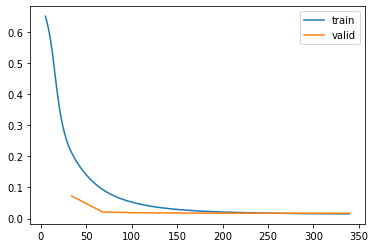

In [20]:
learn.recorder.plot_loss()

In [21]:
#Get Predictions for Submission
#We follow the guide to setting up a test set here: https://forums.fast.ai/t/a-brief-guide-to-test-sets-in-v2-you-can-do-labelled-now-too/57054
#testset
test_dl = dls.test_dl(test_features)

In [22]:
test_dl.show(5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680

In [23]:
preds,_ = learn.get_preds(dl=test_dl)

In [24]:
preds_df = pd.DataFrame(preds).astype("float")

In [25]:
preds_df.head

<bound method NDFrame.head of            0         1         2         3         4         5         6    \
0     0.002095  0.002007  0.001696  0.014726  0.007903  0.005439  0.004688   
1     0.000050  0.000364  0.000931  0.001506  0.002189  0.001921  0.001494   
2     0.000043  0.000073  0.002073  0.004539  0.003697  0.002310  0.003363   
3     0.000030  0.000050  0.002268  0.002876  0.000800  0.001125  0.000931   
4     0.000793  0.000351  0.001146  0.007161  0.012059  0.001967  0.003985   
...        ...       ...       ...       ...       ...       ...       ...   
3977  0.000063  0.000389  0.000736  0.001803  0.002971  0.001779  0.000354   
3978  0.001797  0.000520  0.000383  0.007378  0.028659  0.003369  0.003223   
3979  0.000096  0.000186  0.000379  0.004873  0.029594  0.004831  0.001095   
3980  0.000106  0.000211  0.001419  0.032348  0.049565  0.014144  0.003965   
3981  0.000081  0.000230  0.000418  0.004177  0.005662  0.001965  0.000773   

           7         8         9 

In [26]:
submission = sub
submission[dep_var] = preds_df
submission.loc[test_features['cp_type']=='ctl_vehicle', dep_var] = 0

In [27]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.002095,0.002007,0.001696,0.014726,0.007903,0.005439,0.004688,0.009622,0.001748,...,0.000286,0.002039,0.004426,0.004786,0.000921,0.000708,0.000946,0.002751,0.001904,0.001640
1,id_001897cda,0.000050,0.000364,0.000931,0.001506,0.002189,0.001921,0.001494,0.006164,0.000957,...,0.000322,0.000836,0.001261,0.000497,0.027885,0.000158,0.008697,0.000683,0.013515,0.002090
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000030,0.000050,0.002268,0.002876,0.000800,0.001125,0.000931,0.002713,0.000162,...,0.000105,0.000517,0.001092,0.087776,0.005437,0.000044,0.009684,0.000266,0.003074,0.001270
4,id_0027f1083,0.000793,0.000351,0.001146,0.007161,0.012059,0.001967,0.003985,0.003406,0.000400,...,0.000188,0.000647,0.002194,0.001015,0.000384,0.000243,0.000327,0.001328,0.002154,0.001246


In [28]:
submission.to_csv('submission.csv', index=False)